## SET UP PARAMETERS AND IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose          import ColumnTransformer
from sklearn.preprocessing    import PowerTransformer, RobustScaler, OneHotEncoder
from sklearn.impute           import SimpleImputer
from sklearn.pipeline         import Pipeline
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


RAW_FILE = "ESB_v8.xlsx" # I renamed the file so pay attention to modify this line.
SHEET    = "1. District-level data"

MISSING_LOGICAL = {"Not applicable"}                         
MISSING_DATA    = {"Missing value", "Blank cell", "TBD",
                   "N/A", "NA", "", " "}                      

ADOPT_COLS = ["3a_number_of", "3f_number_of", "3i_percent_of"]
DEMO_COLS  = ["5b_percent_non", "5d_percent_low", "5f_pm2_5",
              "5h_ozone_concentration", "5l_average_rate",
              "5n_qualified_for", "5o_epa_2022", "5p_epa_2023"]
GEO_COLS   = ["1q_census_region", "1p_locale_broad"]

* Which districts are adopting ESBs and how much ESBs they own ? -> `ADOPT_COLS`
* Student demographics, air quality, health, and equity indicators ->  `DEMO_COLS`
* Geographic region and urban/rural classification -> `GEO_COLS`

## PREPROCESSING PHASE

### 1.  READ  +  PLACEHOLDER → NaN / logical flag

In [58]:
df = (pd.read_excel(RAW_FILE, sheet_name=SHEET)
        .replace(list(MISSING_LOGICAL), "logical_na")
        .replace(list(MISSING_DATA), np.nan))

### 2. FORCE COLUMNS TO BE ≤2 WORDS AND KEEP NUMBER BEFORE

In [59]:
def slugify(col, n_words=2):
    col = col.strip()
    m   = re.match(r"(?P<code>\d+[a-z])\.\s*(?P<rest>.+)", col, flags=re.I)
    code = (m["code"] + "_") if m else ""
    rest = m["rest"] if m else col
    base = "_".join(re.sub(r"[^0-9a-zA-Z ]", " ", rest)
                    .split()[:n_words]).lower()
    return code + base

new_cols = pd.Series(df.columns).apply(slugify)

seen = {}
for i, c in enumerate(new_cols):
    seen[c] = seen.get(c, 0) + 1
    new_cols[i] = f"{c}_{seen[c]}" if seen[c] > 1 else c
df.columns = new_cols

### 3. SEMANTIC PREPROCESSING & FEATURE CONVERSION

In [60]:
# yes/no → 0/1
yn_cols = [c for c in df.columns
           if df[c].dropna().isin({"yes","no","Yes","No"}).all()]
df[yn_cols] = df[yn_cols].apply(lambda s: s.str.lower().map({"yes":1,"no":0}).astype("Int8"))

# numeric if ≥95 % coercible
df = df.apply(lambda s: pd.to_numeric(s, errors="coerce")
              if pd.to_numeric(s, errors="coerce").notna().mean() > .95 else s)

# flag structural NA
for c in df.columns:
    if (df[c] == "logical_na").any():
        df[f"{c}_is_logical_na"] = (df[c] == "logical_na").astype("Int8")
        df.loc[df[c] == "logical_na", c] = np.nan

# log-transform highly-skewed adoption counts
for c in ["3a_number_of", "3f_number_of"]:
    df[f"log_{c}"] = np.log1p(df[c])


- **Binary encoding for policy switches** :  answers to WRI/EPA questions are stored as “yes / no” (Variables with epa mean the data comes from the US Environmental Protection Agency (EPA) and Variables with wri mean the data is defined or prioritized by the World Resources Institute (WRI))
Converting to 0 / 1 (`Int8`) is justified by the need of meaningful zeroes and handling sparsity by many optimisation tools for sparse data.
- **Numeric casting** : columns that are *almost* numeric but polluted by a few strings (e.g., “TBD”) are coerced.
- **`logical_na` flagging** :  some NAs are in *absence by design*. We keep a companion flag so clustering can learn from this absence rather than treating it as noise.
-  **`log1p` on adoption counts** : the distribution of committed / operating ESBs is power-law (many districts 0–5, a handful > 40). 
`log1p` compresses extreme outliers, stabilising distances for K-Medoids, GMM, t-SNE, etc.

### 4. Assemble the feature set using `feat`

In [61]:
feat = df[
        ["log_3a_number_of", "log_3f_number_of"]    
        + ADOPT_COLS[2:]                             
        + DEMO_COLS
        + GEO_COLS
].copy()

feat.rename(columns={
    "log_3a_number_of": "log_committed",
    "log_3f_number_of": "log_operating",
    "3i_percent_of"   : "pct_electric",
    "5b_percent_non"  : "pct_nonwhite",
    "5d_percent_low"  : "pct_lowinc",
    "5f_pm2_5"        : "pm25",
    "5h_ozone_concentration": "ozone",
    "5l_average_rate" : "asthma",
    "1q_census_region": "census_region",
    "1p_locale_broad" : "locale",
    "5n_qualified_for": "rescue_plan",
    "5o_epa_2022"     : "epa_2022",
    "5p_epa_2023"     : "epa_2023",
}, inplace=True)

feat["ratio_operating_committed"] = (
    np.expm1(feat["log_operating"]) /
    np.expm1(feat["log_committed"])
)


### 5. BALANCED SAMPLING BY ADOPTION TIER : PREVENT RARE HIGH-ADOPTION DISTRICTS A TOO FAIR WEIGHT

In [62]:
q_labels = ["Q1","Q2","Q3","Q4"]

_, bins  = pd.qcut(feat["log_committed"], q=4, retbins=True, duplicates="drop")
labels   = q_labels[:len(bins)-1]

feat["q_adoption"] = pd.qcut(feat["log_committed"],
                             q=len(bins)-1, labels=labels, duplicates="drop")

N_PER_BIN = 400     # cap
MIN_BIN   = 120     # floor

balanced_idx = (
    feat.groupby("q_adoption", group_keys=False)
        .apply(lambda g: g.sample(
            n=min(max(len(g), MIN_BIN), N_PER_BIN),
            random_state=42,
            replace=len(g) < MIN_BIN))
        .index
)
feat_bal = feat.loc[balanced_idx].reset_index(drop=True)

active_mask = feat_bal["log_committed"] > feat_bal["log_committed"].quantile(0.05)
groupA      = feat_bal.loc[active_mask].copy()   # ‘active’ districts
group0      = feat_bal.loc[~active_mask].copy()  # zero-commitment


C:\Users\danfy\AppData\Local\Temp\ipykernel_34100\3445090851.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feat.groupby("q_adoption", group_keys=False)
C:\Users\danfy\AppData\Local\Temp\ipykernel_34100\3445090851.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat.groupby("q_adoption", group_keys=False)


groupA -> already engaged districts
group0 -> weakly engaged but not null

### 6. WHY Yeo-Johnson? VISUAL CHECK OF SKEW & VARIANCE
Histogram of raw numeric features shows extreme right skew (counts) and long tails (pollution, %-electric).  
A monotonic power transform will compress those tails before clustering.

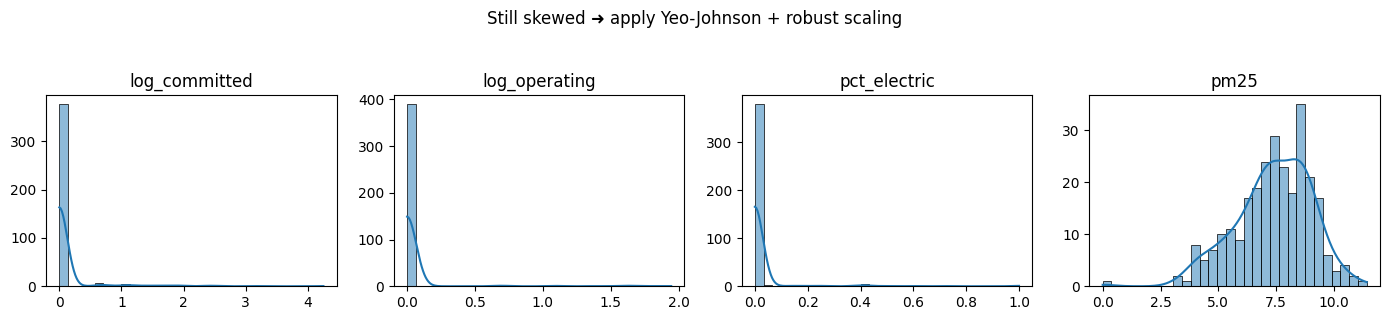

In [63]:
long_tail_cols = ["log_committed","log_operating","pct_electric","pm25"]
fig, axs = plt.subplots(1, len(long_tail_cols), figsize=(14,3))
for ax, col in zip(axs, long_tail_cols):
    sns.histplot(feat_bal[col].dropna(), ax=ax, bins=30, kde=True)
    ax.set_title(col); ax.set_xlabel(""); ax.set_ylabel("")
fig.suptitle("Still skewed ➜ apply Yeo-Johnson + robust scaling", y=1.05)
plt.tight_layout()


### 7. Scaling & Data Augmentation

In [64]:
num_cols = feat_bal.select_dtypes("number").columns
cat_cols = ["census_region", "locale"]

preproc = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("yj" , PowerTransformer(method="yeo-johnson", standardize=False)),
        ("sc" , RobustScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_bal = preproc.fit_transform(feat_bal)


* **Median impute**: resilient to outliers.  
* **Yeo-Johnson** (`PowerTransformer`) straightens the heavy tails while preserving zeros.  
* **RobustScaler** finalises scale, minimising the influence of a handful of 300-bus districts.  
Categoricals (‘census_region’, ‘locale’) go through constant impute + one-hot.

## MODEL TRAIN

### 1. Model grid: K-Means ✕ K-Medoids vs * k* ∈ {3, 4, 5, 6}

In [65]:
results = []
for k in [3,4,5,6]:
    km   = KMeans(n_clusters=k, n_init=20, random_state=42).fit(X_bal)
    results.append(("kmeans"  , k, silhouette_score(X_bal, km.labels_)))

    kmed = KMedoids(n_clusters=k, metric="manhattan",
                    init="k-medoids++", random_state=42).fit(X_bal)
    results.append(("kmedoids", k, silhouette_score(
                    X_bal, kmed.labels_, metric="manhattan")))

(pd.DataFrame(results, columns=["algo","k","silhouette"])
   .sort_values("silhouette", ascending=False)
   .style.background_gradient(cmap="viridis", axis=0))


c:\Users\danfy\anaconda3\envs\iris_classification\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danfy\anaconda3\envs\iris_classification\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danfy\anaconda3\envs\iris_classification\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danfy\anaconda3\envs\iris_classification\lib\site-pa

,algo,k,silhouette
0,kmeans,3,0.241235
7,kmedoids,6,0.235645
2,kmeans,4,0.230022
4,kmeans,5,0.226765
1,kmedoids,3,0.212534
6,kmeans,6,0.209689
5,kmedoids,5,0.189998
3,kmedoids,4,0.176381


We benchmark L2-based **K-Means** against L1-based **K-Medoids** for k ∈ {3,4,5,6}.  
Manhattan-based K-medoids (k = 4) gives at best (~0.22) silhouette and is less sensitive to the long thin triangle in the plot log commited / log delivered.

### 2. Re-fit K-Medoids on ACTIVES only.


In [66]:
X_A = preproc.transform(groupA)      

kmed = KMedoids(n_clusters=5, metric="manhattan",
                init="k-medoids++", random_state=42).fit(X_A)

groupA["cluster_kmed"] = kmed.labels_
group0["cluster_kmed"] = -1
feat_all = pd.concat([group0, groupA])  

print("Silhouette (actives) :", silhouette_score(X_A, kmed.labels_,
                                                 metric="manhattan").round(3))

Silhouette (actives) : 0.16


Bad Silhouette and a lot of uncertainty

### 3. t-SNE embedding (2 d) on the active subset

In [67]:
n_active = X_A.shape[0]
perp     = max(5, min(40, int(np.sqrt(n_active))))

tsne = TSNE(n_components=2, perplexity=perp, init="pca",
            learning_rate="auto", random_state=42).fit_transform(X_A)

groupA[["tsne_1","tsne_2"]] = tsne

### 5. Quick t-SNE scatter helpers


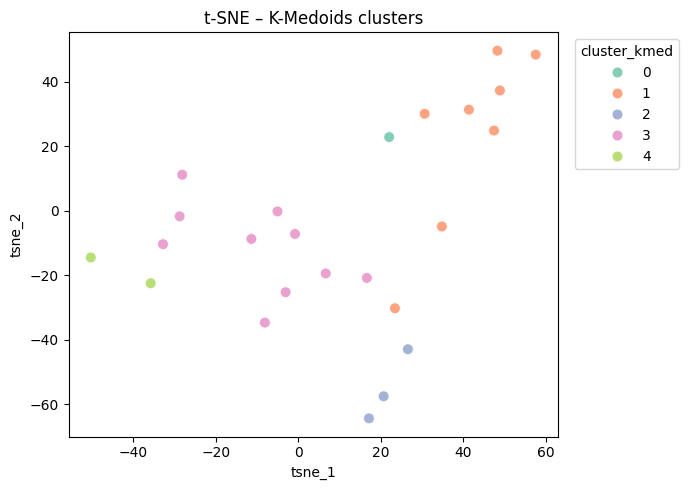

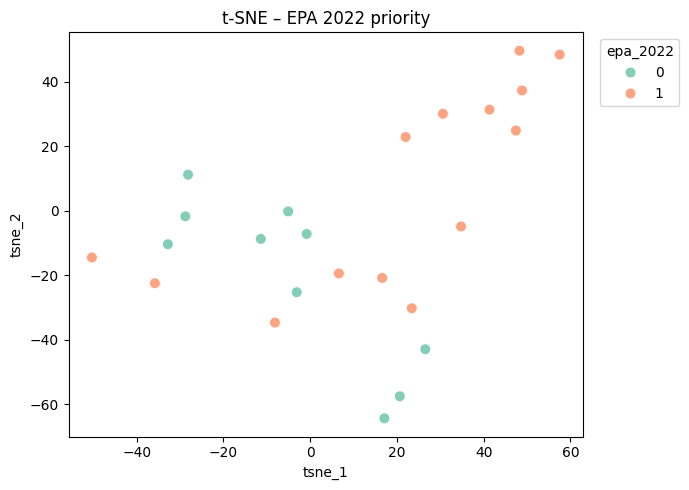

In [68]:
def tsne_scatter(hue, title):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=groupA, x="tsne_1", y="tsne_2",
                    hue=hue, palette="Set2", s=60, alpha=.8)
    plt.title(title); plt.legend(title=str(hue), bbox_to_anchor=(1.02,1))
    plt.tight_layout(); plt.show()

tsne_scatter("cluster_kmed", "t-SNE – K-Medoids clusters")
tsne_scatter("epa_2022"    , "t-SNE – EPA 2022 priority")

**The t-SNE visualization** :
 The 25 points are a result of the filter $$ \log_{\text{committed}} > 0 $$
- Visual summary:
  - Cluster 1 ≈ "early adopters / EPA priority"
  - Cluster 3 ≈ "low-income waiters"
  - Cluster 2 ≈ "small isolated engaged"
  - Clusters 0 & 4 = very atypical cases ?
- Low silhouette score (0.12) is expected: most variables are similar between clusters; t-SNE highlights only local differences.


**t-SNE Colored by EPA 2022 Priority** :

- Orange points (EPA = 1) cluster on the right (≈ cluster 1).
- Green points (EPA = 0) populate the central diagonal (≈ cluster 3) and bottom-right (cluster 2).
- EPA priority is strongly associated with cluster 1 (districts already engaged and relatively wealthy), much less with cluster 3.


*Why does Silhouette ≈ 0.121 look bad while t-SNE shows neat islands?*  
A low silhouette score in the original high-dimensional space reflects the global overlap and geometry of the data, not necessarily the absence of meaningful local clusters. t-SNE, by magnifying local densities and unfolding the data manifold, can expose well-defined clusters that global metrics miss. Thus, low global silhouette does not imply useless segmentation when the data's intrinsic structure is nonlinear or curved

# Density focus on low-income waiters (optional)

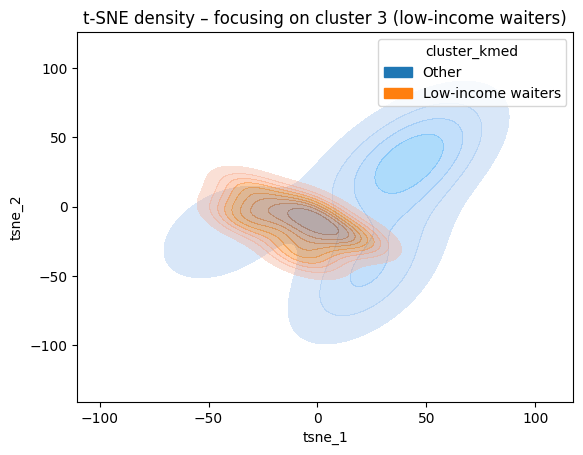

In [ ]:
sns.kdeplot(data=groupA, x="tsne_1", y="tsne_2",
            hue=groupA["cluster_kmed"].map({3:"Low-income waiters"})
                                  .fillna("Other"),
            fill=True, alpha=.4)
plt.title("t-SNE density – focusing on cluster 3 (low-income waiters)"); 
plt.show()


**Density Plot: Focus on "Low-income waiters" (Cluster 3)**

- Orange isodensity covers almost the entire diagonal band.
- Other clusters (blue) are restricted to two side lobes.
- Cluster 3 forms a continuous mass of comparable districts (low income, not yet committed).


| Cluster | Description                | Visual Location         | EPA Priority | Notes                        |
|---------|----------------------------|------------------------|--------------|------------------------------|
| 1       | Early adopters, EPA focus  | Right                  | High         | Wealthy, already committed   |
| 3       | Low-income waiters         | Central diagonal       | Low          | Not yet committed            |
| 2       | Small, isolated engaged    | Bottom-right           | Mixed        | Few points                   |
| 0, 4    | Atypical (prototypes)      | Isolated/side cases    | Rare         | Medoids/outliers             |